# Avazu CTR广告点击率预测（lightGBM）

* Content：对Netflix数据集进行评分预测
* Author:  HuiHui
* Date:    2020-06-01
* Reference:https://www.kaggle.com/c/avazu-ctr-prediction

## 提交说明

* 说明采用的模型，LogLoss值
* 提交结果，评分截图

## Avazu数据集

* **训练集：**10天的点击数据，按时间顺序排列。根据不同的策略对非点击和点击进行二次采样。
* **测试集：** 1天的广告用于测试模型   
* **提交文件：**
* **字段：**  
&emsp;**click:** 0-不点击，1-点击   
&emsp;**C1，C14-C21：**匿名分类变量  
&emsp;**hour:** 格式为YYMMDDHH

## 导入相关库

In [5]:
# !/usr/bin/env python
# -*- coding=utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.preprocessing import LabelEncoder
from dummyPy import OneHotEncoder
import random
import pickle  # 存储临时变量

from sklearn.linear_model import SGDClassifier  # 梯度下降分类
from sklearn.metrics import log_loss
import lightgbm as lgb
from sklearn.model_selection import train_test_split

## 数据预处理

* 特征选择  
* 绘制分类数据分布图
* 将所有不常用的分类转换成'other'
* LabelEncoder、OneHotEncoder
* 下采样训练样本

loading data...


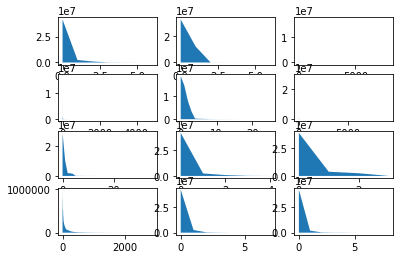

In [2]:
## 读文件
# file_path = '/Users/wangdonghui/Desktop/ZGZ/RS/dataset/avazu-ctr-prediction/' # mac路径
file_path = 'C:/Users/Administrator/Desktop/W/DataSet/avazu/' # win路径
fp_train = file_path + 'train.csv'
fp_test  = file_path + 'test.csv'

## 下采样写文件
fp_sub_train_f = file_path + 'sub_train_f.csv'
fp_col_counts = file_path + 'col_counts'

## data after selecting features (LR_fun needed)
## and setting rare categories' value to 'other' (feature filtering)
fp_train_f = file_path + 'train_f.csv'
fp_test_f  = file_path + 'test_f.csv'

## 存储标签编码和one-hot编码
fp_lb_enc = file_path + 'lb_enc'
fp_oh_enc = file_path + 'oh_enc'

##==================== 数据预处理 ====================##
# 特征选择
cols = ['C1', 
        'banner_pos', 
        'site_domain', 
        'site_id',
        'site_category',
        'app_id',
        'app_category', 
        'device_type', 
        'device_conn_type',
        'C14', 
        'C15',
        'C16']

cols_train = ['id', 'click']
cols_test  = ['id']
cols_train.extend(cols)
cols_test.extend(cols)

## 数据加载
print('loading data...')
df_train_ini = pd.read_csv(fp_train, nrows = 10)# nrows = 10读取一个大文件中的几行数据
df_train_org = pd.read_csv(fp_train, chunksize = 10000000, iterator = True)# 分块读取,iterator = True返回一个可迭代对象TextFileReader,reader.get_chunk(5)返回前五条数据
df_test_org  = pd.read_csv(fp_test,  chunksize = 10000000, iterator = True)

# print(df_train_ini.head())
# print("=="*50)
# print(df_train_org.get_chunk(5))
# print("=="*50)
# print(df_test_org.get_chunk(5))

#----- 统计分类变量 数值个数 -----#
## 初始化
cols_counts = {}  # 统计每个特征的分类数量
for col in cols:
    cols_counts[col] = df_train_ini[col].value_counts()

## 统计训练集
for chunk in df_train_org:
    for col in cols:
        cols_counts[col] = cols_counts[col].append(chunk[col].value_counts())   

## 统计测试集
for chunk in df_test_org:
    for col in cols:
        cols_counts[col] = cols_counts[col].append(chunk[col].value_counts())

## 统计      ??? 多统计了一次df_train_ini的特征
for col in cols:
    cols_counts[col] = cols_counts[col].groupby(cols_counts[col].index).sum()
    # sort the counts
    cols_counts[col] = cols_counts[col].sort_values(ascending=False)   

## 存储value_counting
pickle.dump(cols_counts, open(fp_col_counts, 'wb'))

## 绘制分布
fig = plt.figure(1)
for i, col in enumerate(cols):
    ax = fig.add_subplot(4, 3, i+1)
    ax.fill_between(np.arange(len(cols_counts[col])), cols_counts[col].get_values())
    # ax.set_title(col)
plt.show()

In [3]:
## 只保存前K个分类变量
k = 99
col_index = {}
for col in cols:
    col_index[col] = cols_counts[col][0: k].index

df_train_org = pd.read_csv(fp_train, dtype = {'id': str}, chunksize = 10000000, iterator = True)
df_test_org  = pd.read_csv(fp_test,  dtype = {'id': str}, chunksize = 10000000, iterator = True)

## 训练集
hd_flag = True  # add column names at 1-st row
for chunk in df_train_org:
    df = chunk.copy()
    for col in cols:
        df[col] = df[col].astype('object')
        # 将所有稀有的分类转换成'other'
        df.loc[~df[col].isin(col_index[col]), col] = 'other'    ####？？？？？？
    with open(fp_train_f, 'a') as f:
        df.to_csv(f, columns = cols_train, header = hd_flag, index = False)
    hd_flag = False

## 测试集
hd_flag = True  # 第一个chunk需要有header
for chunk in df_test_org:
    df = chunk.copy()
    for col in cols:
        df[col] = df[col].astype('object')
        # 设置其他不常用变量为other
        df.loc[~df[col].isin(col_index[col]), col] = 'other'
    with open(fp_test_f, 'a') as f:
        df.to_csv(f, columns = cols_test, header = hd_flag, index = False)      
    hd_flag = False    

print("ok")

ok


In [4]:
## 对分类变量进行标签编码
lb_enc = {}
for col in cols:
    col_index[col] = np.append(col_index[col], 'other')

for col in cols:
    lb_enc[col] = LabelEncoder()
    lb_enc[col].fit(col_index[col])
    
## 存储标签编码
pickle.dump(lb_enc, open(fp_lb_enc, 'wb'))

## one-hot编码
oh_enc = OneHotEncoder(cols)

df_train_f = pd.read_csv(fp_train_f, index_col=None, chunksize=5000000, iterator=True)
df_test_f  = pd.read_csv(fp_test_f, index_col=None, chunksize=5000000, iterator=True)

for chunk in df_train_f:
    oh_enc.fit(chunk)
for chunk in df_test_f:
    oh_enc.fit(chunk)
    
## 存储one-hot编码
pickle.dump(oh_enc, open(fp_oh_enc, 'wb'))

print("ok")

ok


In [ ]:
# 计算总训练样本 约46M
n = sum(1 for line in open(fp_train_f)) - 1 
# 保存下采样训练样本 2M
s = 2000000

## 设置哪些行不需要读 skip，不需要读的行数为n-s
skip = sorted(random.sample(range(1, n+1), n-s)) 
df_train = pd.read_csv(fp_train_f, skiprows = skip)
df_train.columns = cols_train

## 存储下采样的结果
df_train.to_csv(fp_sub_train_f, index=False) 

print("ok")

## CTR预测（LR）

training...
training...
LR model saved
[0.5902272122294253, 0.5590883409976604]


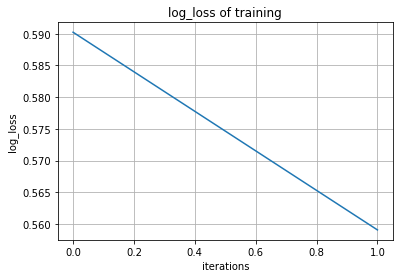

predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predic

In [9]:
##==================== 设置文件路径File-Path (fp) ====================##
file_path = '/Users/wangdonghui/Desktop/ZGZ/RS/dataset/avazu-ctr-prediction/' # mac路径
# file_path = 'C:/Users/Administrator/Desktop/W/DataSet/avazu/' # win路径

# 全量样本
fp_train_f = file_path + "train_f.csv"
# 小样本
fp_sub_train_f = file_path + 'sub_train_f.csv'

fp_test_f  = file_path + "test_f.csv"

# one-hot编码保存
fp_oh_enc = file_path + "oh_enc"
# LR模型保存
fp_lr_model = file_path + "lr/lr_model"
# submission文件保存
fp_sub = file_path + "lr/LR_submission.csv"

##==================== LR模型 训练 ====================##
oh_enc = pickle.load(open(fp_oh_enc, 'rb'))

# 一个chunk块为5万行
chunksize = 50000
# df_train_f = pd.read_csv(fp_train_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True) # 读取全量样本
df_train_f = pd.read_csv(fp_sub_train_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True) # 读取小样本
# print(df_train_f.get_chunk(5))

# 使用LogLoss作为LR的损失函数
lr_model = SGDClassifier(loss='log')  
scores = []

# 使用k和i调整训练规模，训练样本 = 所有样本 / k
k = 20 #100  
i = 1
for chunk in df_train_f:
    # 根据K drop掉样本
    if i < k: 
        i += 1
        continue
    print('training...')
    i = 1
    df_train = oh_enc.transform(chunk)
    # LR训练
    feature_train = df_train.columns.drop(['id', 'click'])
    train_X = df_train[feature_train]
    train_y = df_train['click'].astype('int')
    lr_model.partial_fit(train_X, train_y, classes = [0,1])  # fitting
    
    # 训练结果logloss分数
    y_pred = lr_model.predict_proba(train_X)[:, 1]
    score = log_loss(train_y, y_pred)
    scores.append(score)

## 存储训练好的LR模型
pickle.dump(lr_model, open(fp_lr_model, 'wb'))
print('LR model saved')

print(scores)
#scores = [0.1, 0.2, 0.3, 0.4]
## 绘制LR训练分数曲线
#f1 = plt.figure(1)
plt.title("LR Training Curve") 
plt.plot(scores)
plt.xlabel('iterations')
plt.ylabel('log_loss')
plt.title('log_loss of training')
plt.grid()
plt.show()

import gc
del lr_model
del df_train_f
gc.collect()

##==================== 使用训练好的LR模型进行预测，提交submission ====================##
df_test_f = pd.read_csv(fp_test_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True)        
lr_model = pickle.load(open(fp_lr_model, 'rb'))

# 按照chunk对测试集进行预测
header = True
for chunk in df_test_f:
    print('predicting...')
    df_test = oh_enc.transform(chunk)
    # 去掉ID字段
    feature_test = df_test.columns.drop(['id'])
    test_X = df_test[feature_test]
    # 计算class=1的概率
    y_pred = lr_model.predict_proba(test_X)[:, 1]  
    # 得到submittion
    chunk['click'] = y_pred
    with open(fp_sub, 'a') as f: 
        # 只有第一次header=True，其余header=False
        chunk.to_csv(f, columns=['id', 'click'], header=header, index=False) 
    header = False

print('submittion completed')

## CTR预测（lightGBM）

In [16]:
##==================== 设置文件路径File-Path (fp) ====================##
# file_path = '/Users/wangdonghui/Desktop/ZGZ/RS/dataset/avazu-ctr-prediction/' # mac路径
file_path = 'C:/Users/Administrator/Desktop/W/DataSet/avazu/' # win路径

# 全量样本
fp_train_f = file_path + "train_f.csv"
# 小样本
fp_sub_train_f = file_path + 'sub_train_f.csv'
fp_test_f  = file_path + "test_f.csv"

# 标签编码保存
fp_lb_enc = file_path + 'lb_enc'
# one-hot编码保存
fp_oh_enc = file_path + "oh_enc"
# lightgbm模型保存
fp_lgb_model = file_path + "lgb/lgb_model"
# submission文件保存
fp_sub = file_path + "lgb/lgb_submission.csv"

##==================== 数据加载 数据处理 ====================##
# lb_enc = pickle.load(open(fp_lb_enc, 'rb'))

# 一个chunk块为5万行
chunksize = 50000
# df_train_f = pd.read_csv(fp_train_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True) # 读取全量样本
df_train_f = pd.read_csv(fp_sub_train_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True) # 读取小样本

# ？？？？？ValueError: DataFrame.dtypes for data must be int, float or bool.
# df_train_f.info()


##==================== lightgbm模型 训练 ====================##
# 使用LogLoss作为LR的损失函数
lgb_params = {
    'boosting_type':'gbdt',
    'objective' : 'binary_logloss', #任务类型
    'metric' : 'auc', #评估指标
    'learning_rate' : 0.01, #学习率
    'max_depth' : 15, #树的最大深度
    'feature_fraction':0.8, #设置在每次迭代中使用特征的比例
    'bagging_fraction': 0.9, #样本采样比例
    'bagging_freq': 8, #bagging的次数
    'lambda_l1': 0.6, #L1正则
    'lambda_l2': 0, #L2正则
}

print("training...")

X_train, X_valid, y_train, y_valid = train_test_split(df_train.drop(['id', 'click'],axis=1), df_train['click'], test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)
lgb_model = lgb.train(lgb_params,train_data,valid_sets=[train_data,valid_data],num_boost_round = 10000 ,early_stopping_rounds=200,verbose_eval=25, categorical_feature="click")


# # 使用k和i调整训练规模，训练样本 = 所有样本 / k
# k = 20 #100  
# i = 1
# for chunk in df_train_f:
#     # 根据K drop掉样本
#     if i < k: 
#         i += 1
#         continue
#     print('training...')
#     i = 1
#     df_train = oh_enc.transform(chunk)
#     # 训练
#     feature_train = df_train.columns.drop(['id', 'click'])
#     train_X = df_train[feature_train]
#     train_y = df_train['click'].astype('int')
#     lgb_model.partial_fit(train_X, train_y, classes = [0,1])  # fitting
    
#     # 训练结果logloss分数
#     y_pred = lgb_model.predict_proba(train_X)[:, 1]
#     score = log_loss(train_y, y_pred)
#     scores.append(score)

## 存储训练好的lightgbm模型
pickle.dump(lgb_model, open(fp_lgb_model, 'wb'))
print('lightGBM model saved')


import gc
del lgb_model
del df_train_f

gc.collect()

##==================== 使用训练好的LR模型进行预测，提交submission ====================##
# predict=lgb_model.predict(test)
# test['Attrition']=predict
# # 转化为二分类输出
# test['Attrition']=test['Attrition'].map(lambda x:1 if x>=0.5 else 0)
# test[['Attrition']].to_csv('submit_lgb.csv')

# df_test_f = pd.read_csv(fp_test_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True)        
# lr_model = pickle.load(open(fp_lr_model, 'rb'))

# # 按照chunk对测试集进行预测
# header = True
# for chunk in df_test_f:
#     print('predicting...')
#     df_test = oh_enc.transform(chunk)
#     # 去掉ID字段
#     feature_test = df_test.columns.drop(['id'])
#     test_X = df_test[feature_test]
#     # 计算class=1的概率
#     y_pred = lr_model.predict_proba(test_X)[:, 1]  
#     # 得到submittion
#     chunk['click'] = y_pred
#     with open(fp_sub, 'a') as f: 
#         # 只有第一次header=True，其余header=False
#         chunk.to_csv(f, columns=['id', 'click'], header=header, index=False) 
#     header = False

print('submittion completed')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 14 columns):
id                  object
click               int64
C1                  int64
banner_pos          int64
site_domain         object
site_id             object
site_category       object
app_id              object
app_category        object
device_type         int64
device_conn_type    int64
C14                 object
C15                 int64
C16                 int64
dtypes: int64(7), object(7)
memory usage: 213.6+ MB
ok
training...


D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['c', 'c', 'i', 'k', 'l']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: C1_1001, C1_1002, C1_1005, C1_1007, C1_1008, C1_1010, C1_1012, banner_pos_0, banner_pos_1, banner_pos_2, banner_pos_3, banner_pos_4, banner_pos_5, banner_pos_7, site_domain_08facbad, site_domain_0a4015b2, site_domain_0d3cb7be, site_domain_0dde25ec, site_domain_16a36ef3, site_domain_17d996e6, site_domain_1b32ed33, site_domain_1e0acfb4, site_domain_1e334bd3, site_domain_2296b5b3, site_domain_250469f8, site_domain_272c5d9d, site_domain_27e3c518, site_domain_28f93029, site_domain_2c5a2165, site_domain_2d235ae0, site_domain_30518255, site_domain_3f2f3819, site_domain_422b8953, site_domain_449497bc, site_domain_4c26e9ba, site_domain_510bd839, site_domain_5449fde7, site_domain_58a89a43, site_domain_5b626596, site_domain_5c9ae867, site_domain_5c9c05b7, site_domain_5dddf09e, site_domain_61eac15d, site_domain_64778742, site_domain_6b560cc1, site_domain_6b59f079, site_domain_6bdbd889, site_domain_6dbd48f0, site_domain_6e882918, site_domain_7256c623, site_domain_759d1c56, site_domain_75f9ddc3, site_domain_7687a86e, site_domain_77c8e77d, site_domain_7804dea6, site_domain_7d05db75, site_domain_7e091613, site_domain_7e1e7bdf, site_domain_7e3be6ba, site_domain_8025317b, site_domain_863fa89d, site_domain_8a429b45, site_domain_91cdcccd, site_domain_945bfb4b, site_domain_948ff336, site_domain_964a3bd1, site_domain_968765cd, site_domain_9690165f, site_domain_98572c79, site_domain_98acf46c, site_domain_98e6755b, site_domain_9b421927, site_domain_9b851bd8, site_domain_9cf7de2f, site_domain_9d54950b, site_domain_9eaf88fa, site_domain_9f448720, site_domain_a10eb148, site_domain_a17bde68, site_domain_a434fa42, site_domain_a9bba545, site_domain_ac5abf20, site_domain_ace5b8fd, site_domain_b12b9f85, site_domain_b4598159, site_domain_b9c4ab81, site_domain_bb1ef334, site_domain_bd6d812f, site_domain_bea33b9a, site_domain_c1aa3c04, site_domain_c4342784, site_domain_c4e18dd6, site_domain_c7ca3108, site_domain_c7dcd9d1, site_domain_c8223ee3, site_domain_cc962a1f, site_domain_ce307e01, site_domain_d00b8121, site_domain_d262cf1e, site_domain_d2f72222, site_domain_d733bbc3, site_domain_d7e2f29b, site_domain_db11867b, site_domain_de0f0f82, site_domain_e16ceb4b, site_domain_e2a5dc06, site_domain_f3845767, site_domain_f3ca2e42, site_domain_f415c8a8, site_domain_f6ebf28e, site_domain_f7570339, site_domain_fba7221d, site_domain_fd13bc73, site_domain_other, site_id_0a742914, site_id_0c2fe9d6, site_id_0eb72673, site_id_12fb4121, site_id_16c73019, site_id_178a7b89, site_id_17caea14, site_id_17d1b03f, site_id_1a5c1d83, site_id_1b171d6d, site_id_1fbe01fe, site_id_222acd54, site_id_2328ee8e, site_id_235ba823, site_id_26fa1946, site_id_29229f8e, site_id_2a68aa20, site_id_2b1ddb24, site_id_2fdff0f2, site_id_3281baa7, site_id_38217daf, site_id_3dc2d6de, site_id_43d6df75, site_id_4bf5bbe2, site_id_4e7614cf, site_id_5114c672, site_id_517b8671, site_id_543a539e, site_id_57ef2c87, site_id_57fe1b20, site_id_5b08c53b, site_id_5b4d2eda, site_id_5b787406, site_id_5bcf81a2, site_id_5ee41ff2, site_id_61a8c644, site_id_6256f5b4, site_id_6399eda6, site_id_6c5b482c, site_id_6ec06dbd, site_id_6fcff501, site_id_7294ea0f, site_id_75f43c5a, site_id_763a42b5, site_id_7697ed3e, site_id_78d60190, site_id_791b5571, site_id_7c6576be, site_id_7dd19f44, site_id_801dfefb, site_id_83a0ad1a, site_id_84c7ba46, site_id_856e6d3f, site_id_85f751fd, site_id_88154ade, site_id_887a4754, site_id_89a490f5, site_id_92c7cbe7, site_id_93eaba74, site_id_9a977531, site_id_9e8cf15d, site_id_9e8e8d09, site_id_9ee9dd00, site_id_a7853007, site_id_ac696ed4, site_id_b7e9786d, site_id_b8eae5f9, site_id_b99a2c43, site_id_ba9aee1b, site_id_bb4524e7, site_id_c1fcc9a1, site_id_c54454a2, site_id_c63170c5, site_id_cbb01868, site_id_ce3307ec, site_id_cf3a1767, site_id_d1a51189, site_id_d6137915, site_id_d7f3460b, site_id_d8bb8687, site_id_d9750ee7, site_id_dcc019de, site_id_df7971d4, site_id_e023ba3e, site_id_e151e245, site_id_e3c09f3a, site_id_e4d8dd7b, site_id_e5c60a05, site_id_e7a92cc6, site_id_e8f79e60, site_id_e9ca7d40, site_id_ec47f32a, site_id_ee8b8550, site_id_f0ee33c5, site_id_f61eaaae, site_id_f6cba1bd, site_id_f9c69707, site_id_faf9c1c2, site_id_fec6e632, site_id_other, site_category_0569f928, site_category_110ab22d, site_category_28905ebd, site_category_335d28a8, site_category_3e814130, site_category_42a36e14, site_category_50e219e0, site_category_5378d028, site_category_6432c423, site_category_70fb0e29, site_category_72722551, site_category_74073276, site_category_75fa27f6, site_category_76b2941d, site_category_8fd0aea4, site_category_9ccfa2ea, site_category_a72a0145, site_category_a818d37a, site_category_bcf865d9, site_category_c0dd3be3, site_category_c706e647, site_category_da34532e, site_category_dedf689d, site_category_e787de0e, site_category_f028772b, site_category_f66779e6, app_id_03528b27, app_id_03a08c3f, app_id_04f2be5f, app_id_088b6a7b, app_id_08a53ae7, app_id_090d3a47, app_id_0acbeaa3, app_id_13684a79, app_id_1779deee, app_id_197b4f7f, app_id_1d64ced5, app_id_1dc72b4d, app_id_255a58c8, app_id_27550a3c, app_id_2815f500, app_id_28d3bd59, app_id_2d869bee, app_id_2f6efcf2, app_id_33291962, app_id_3692fd30, app_id_396df801, app_id_39947756, app_id_3bfa19cb, app_id_3c4b944d, app_id_3e2bf98d, app_id_3f2a6cbb, app_id_442cfede, app_id_45aff1a2, app_id_495d447f, app_id_4b08f369, app_id_4e02fbd3, app_id_51cedd4e, app_id_53de0284, app_id_54c5d545, app_id_5adb10d9, app_id_5d74d2a4, app_id_5e3f096f, app_id_66f5e02e, app_id_680e6a92, app_id_685d1c4c, app_id_6fc85e22, app_id_6fef5db2, app_id_73206397, app_id_7358e05e, app_id_75076517, app_id_7c7508aa, app_id_7e7baafa, app_id_85938df3, app_id_8b89048f, app_id_8c0dcd5a, app_id_8dbc921a, app_id_92f5800b, app_id_93d786c6, app_id_95b5e741, app_id_98fed791, app_id_9c13b419, app_id_9f41cdad, app_id_a0a45985, app_id_a0fc55e5, app_id_a2b190d4, app_id_a37bf1e4, app_id_a4869716, app_id_a4db51b9, app_id_a5184c22, app_id_a607e6a7, app_id_a97b17d0, app_id_bdf46af7, app_id_be7c618d, app_id_c105f675, app_id_c3f39675, app_id_c51f82bc, app_id_c776ba2a, app_id_c7f29df3, app_id_c8e3e3c1, app_id_ce183bbd, app_id_cf0327f9, app_id_d292c32f, app_id_d2bb6502, app_id_d36838b1, app_id_d44c074c, app_id_d644e4e7, app_id_d8784af5, app_id_da90aa44, app_id_de97da65, app_id_dfdd226c, app_id_e2a1ca37, app_id_e2fcccd2, app_id_e5f1bafe, app_id_e69a444c, app_id_e96773f0, app_id_e9739828, app_id_ecad2386, app_id_f0d41ff1, app_id_f53417e1, app_id_f757bb8f, app_id_f888bf4c, app_id_fb7c70a3, app_id_febd1138, app_id_ffc6ffd0, app_id_other, app_category_07d7df22, app_category_09481d60, app_category_0bfbc358, app_category_0d82db25, app_category_0f2161f8, app_category_0f9a328c, app_category_18b1e0be, app_category_2281a340, app_category_2fc4f2aa, app_category_4681bb9d, app_category_4b7ade46, app_category_4ce2e9fc, app_category_52de74cf, app_category_5326cf99, app_category_6fea3693, app_category_7113d72a, app_category_71af18ce, app_category_75d80bbe, app_category_79f0b860, app_category_86c1a5a3, app_category_879c24eb, app_category_8ded1f7a, app_category_8df2e842, app_category_a3c42688, app_category_a7fd01ec, app_category_a86a3e89, app_category_bd41f328, app_category_bf8ac856, app_category_cba0e20d, app_category_cef3e649, app_category_d1327cf5, app_category_dc97ec06, app_category_ef03ae90, app_category_f395a87f, app_category_f95efa07, app_category_fc6fa53d, device_type_0, device_type_1, device_type_2, device_type_4, device_type_5, device_conn_type_0, device_conn_type_2, device_conn_type_3, device_conn_type_5, C14_15699, C14_15701, C14_15702, C14_15703, C14_15704, C14_15705, C14_15706, C14_15707, C14_15708, C14_16208, C14_16615, C14_16688, C14_16920, C14_17014, C14_17016, C14_17017, C14_17037, C14_17239, C14_17262, C14_17264, C14_17614, C14_17653, C14_17654, C14_17747, C14_17753, C14_17875, C14_17877, C14_17893, C14_17894, C14_19015, C14_19016, C14_19251, C14_19665, C14_19743, C14_19771, C14_19772, C14_19950, C14_20093, C14_20108, C14_20251, C14_20277, C14_20312, C14_20345, C14_20346, C14_20352, C14_20362, C14_20366, C14_20508, C14_20632, C14_20633, C14_20634, C14_21153, C14_21189, C14_21191, C14_21611, C14_21647, C14_21665, C14_21767, C14_21768, C14_21769, C14_21770, C14_21789, C14_21790, C14_21882, C14_21893, C14_22104, C14_22254, C14_22257, C14_22261, C14_22267, C14_22268, C14_22288, C14_22676, C14_22680, C14_22681, C14_22682, C14_22683, C14_22813, C14_23137, C14_23143, C14_23144, C14_23160, C14_23161, C14_23221, C14_23222, C14_23224, C14_23438, C14_23441, C14_23454, C14_23626, C14_23642, C14_23722, C14_23723, C14_23804, C14_23866, C14_4687, C14_6563, C14_8330, C14_9478, C14_other, C15_120, C15_216, C15_300, C15_320, C15_480, C15_728, C15_768, C15_1024, C16_20, C16_36, C16_50, C16_90, C16_250, C16_320, C16_480, C16_768, C16_1024

## 问题

* 矩阵分解的作用是补全矩阵缺失的评分，但是当预测集中出现训练集中没有的新用户或新电影，矩阵分解(SVD)好像也能得到预测评分，这是为什么呢？